This notebook is used to experiment with different PCA settings.
Two and more dimensional compressed PCA data is visualized in plots with(out) clustering.
The reconstruction error for different number of components is calculated and plotted.

In [2]:
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 600

In [3]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

In [4]:

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

shape of all data:  (194, 360000)


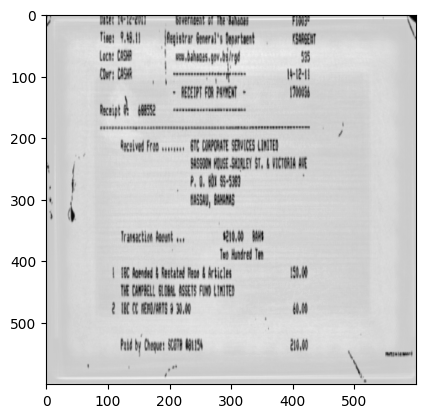

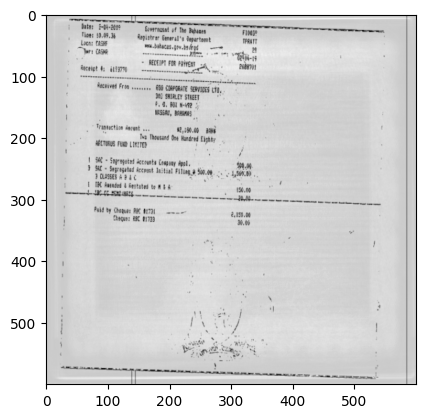

In [5]:

print('shape of all data: ', preprocessed_images_centered.shape)    # (n_samples, n_features)
for img in preprocessed_images_centered[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.show()

In [6]:
# PCA needs more samples than features, cf. https://stackoverflow.com/questions/51040075/why-sklearn-pca-needs-more-samples-than-new-featuresn-components
# otherwise the number of new faetures will be way smaller than the original number of features
# number of components to keep: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
max_components = min(preprocessed_images_centered.shape[0], preprocessed_images_centered.shape[1])
print('max components: ', max_components)
pca = decomposition.PCA(n_components=max_components, svd_solver="randomized", whiten=True)  # SVDSolver eigenfaces
pca_img = pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', pca.components_.shape)    # (n_new_features/ n_components, n_features)
print('PCA return shape: ', pca_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_img)

max components:  194
PCA components:  (194, 360000)
PCA return shape:  (194, 194)
PCA image:  [[-0.34640488 -0.32719484  0.23480852 ... -0.19356656 -0.2661848
   0.997422  ]
 [-0.36624917  0.29773507  0.52970004 ... -0.4686475  -0.06685734
   0.9974194 ]
 [ 0.56696784  0.20585923  9.16004    ... -0.3192249   0.1739502
   0.9974165 ]
 ...
 [-0.20440622 -0.4825452  -0.04633136 ...  0.2283858  -0.01881591
   0.9974217 ]
 [ 3.364787    1.4135679  -0.38263363 ... -0.02489958  0.0739838
   0.99741805]
 [-0.3886411  -0.08938595 -0.4394702  ... -0.11484879  0.07872331
   0.9974222 ]]


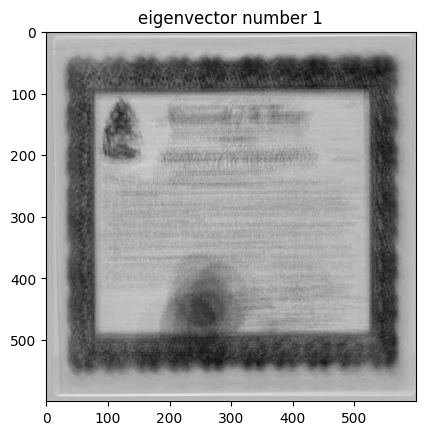

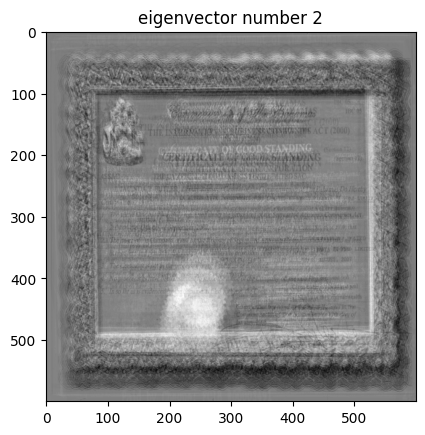

In [7]:
# plot eigenvectors as images
i = 1
for img in pca.components_[:2]: # component is (parallel to) eigenvector, cf. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title('eigenvector number ' + str(i))
    i += 1
    plt.show()

    # compare eigenvectors to get 'what they show (eg. Belichtung, Kontrast, etc.)'
    # TODO: residuals/ rescosntruction error, to see how much information is lost, if representative

In [8]:
# save representation of images in lower dimension (linear combination of eigenvectors) in dataframe
pca_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_img[i]], index=pca_df.index[[i]])

pca_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640488, -0.32719484, 0.23480852, 0.83855..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36624917, 0.29773507, 0.52970004, -0.02564..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696784, 0.20585923, 9.16004, 1.9097525, 5..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844556, 0.3092128, 0.76901597, 0.3911301..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.433655, -0.42421794, -0.5446789, -0.178619..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.3154923, -0.07034489, -0.67870474, -0.0018..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040592, 0.05336686, 0.16824973, 0.259776..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440622, -0.4825452, -0.04633136, 0.08712..."


In [9]:
# identify clusters by similar weights (linear combination) of eigenvectors
NUM_CLASSES = 4
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_df['pca_weights'].to_list())
pca_df['cluster'] = kmeans.labels_
display(pca_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640488, -0.32719484, 0.23480852, 0.83855...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36624917, 0.29773507, 0.52970004, -0.02564...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696784, 0.20585923, 9.16004, 1.9097525, 5...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844556, 0.3092128, 0.76901597, 0.3911301...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.433655, -0.42421794, -0.5446789, -0.178619...",1
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.3154923, -0.07034489, -0.67870474, -0.0018...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040592, 0.05336686, 0.16824973, 0.259776...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440622, -0.4825452, -0.04633136, 0.08712...",1


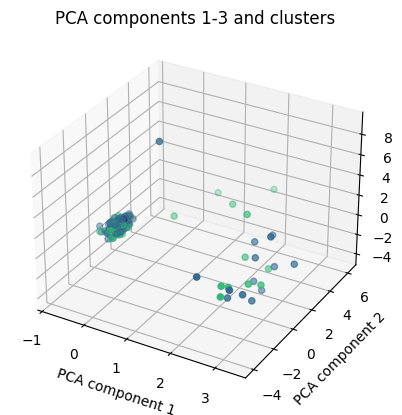

In [10]:
# plot first 3 principal components & clusters
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca_x1 = pca_df['pca_weights'].apply(lambda x: x[0])
pca_x2 = pca_df['pca_weights'].apply(lambda x: x[1])
pca_x3 = pca_df['pca_weights'].apply(lambda x: x[2])

ax.scatter(pca_x1, pca_x2, pca_x3, marker='o', c=pca_df['cluster'])
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_zlabel('PCA component 3')
plt.title('PCA components 1-3 and clusters')

plt.show()

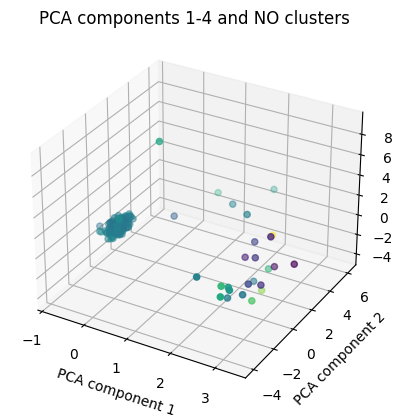

In [11]:
# plot first 4 principal components
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca_x1 = pca_df['pca_weights'].apply(lambda x: x[0])
pca_x2 = pca_df['pca_weights'].apply(lambda x: x[1])
pca_x3 = pca_df['pca_weights'].apply(lambda x: x[2])
pca_x4 = pca_df['pca_weights'].apply(lambda x: x[3])

ax.scatter(pca_x1, pca_x2, pca_x3, marker='o', c=pca_x4)
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_zlabel('PCA component 3')
plt.title('PCA components 1-4 and NO clusters')

plt.show()

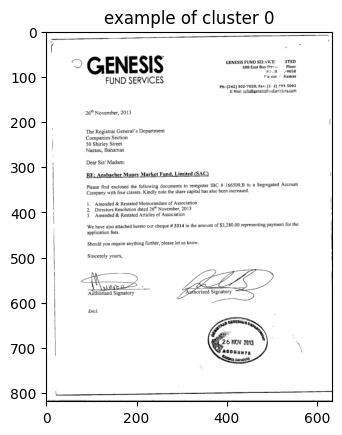

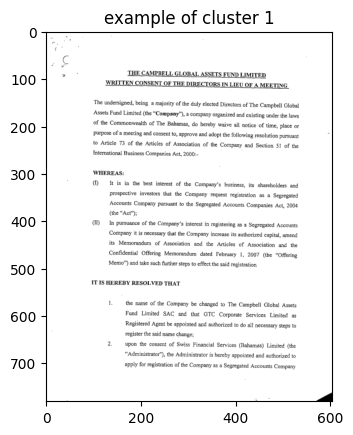

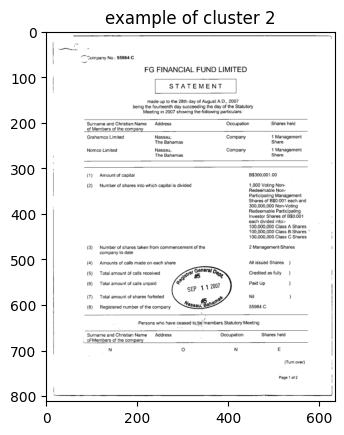

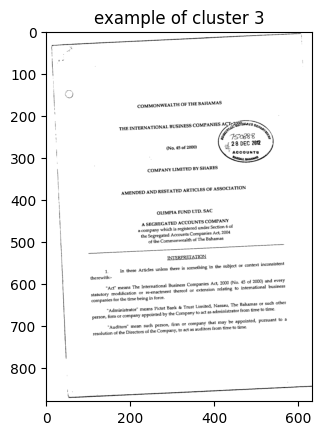

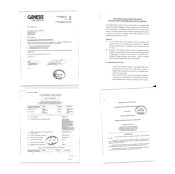

In [12]:
# display sample document per class
example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_df[pca_df['cluster'] == i].sample(1).index.values[0]
    example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of cluster ' + str(i))
    plt.show()

create_image_matrix(example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

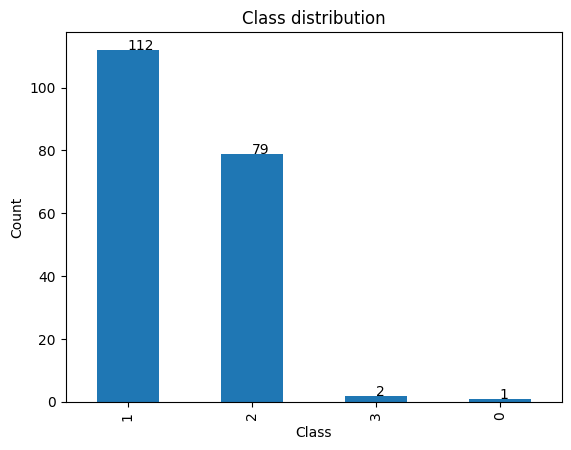

In [13]:
# class/ cluster distribution
pca_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
cluster_counts = pca_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_df['cluster'].value_counts())):
        plt.text(i, cluster_counts[i], cluster_counts[i])

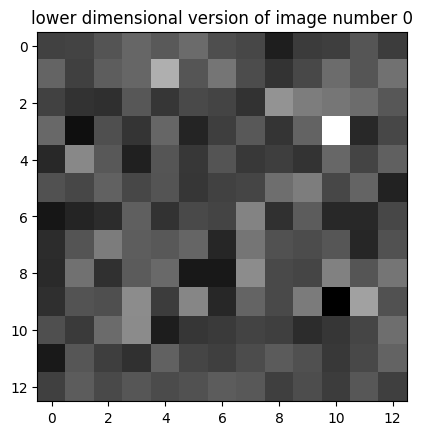

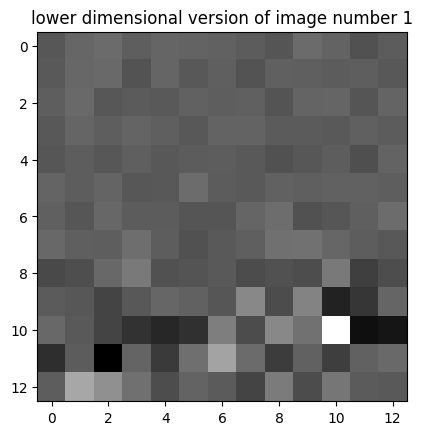

In [14]:
# visualize the compressed data, i.e. the weights/ factors of PCA components, as an image
# transformed pictures in lower dimensional subspace (weights of PCA components)
for i in range(len(pca_img[:2])):
    img = pca_img[i]
    dim = int(sqrt(len(img)))
    # automatically transform image using -1, cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
    quadratic_img = img[:dim**2].reshape(-1, dim)
    plt.imshow(quadratic_img, cmap='gray')
    plt.title('lower dimensional version of image number ' + str(i))
    plt.show()

##### 2 dimensional PCA

In [15]:
# use PCA to reduce dimensionality (image -> point in 2 dimensional space)
# cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
d2_pca = decomposition.PCA(n_components=2, svd_solver="randomized", whiten=True)
pca_2d_img = d2_pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', d2_pca.components_.shape, 'Principal axes in feature space = directions of maximum variance')    # (n_new_features/ n_components, n_features)
print('PCA return/ image shape: ', pca_2d_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_2d_img)

PCA components:  (2, 360000) Principal axes in feature space = directions of maximum variance
PCA return/ image shape:  (194, 2)
PCA image:  [[-3.46405119e-01 -3.26902539e-01]
 [-3.66250038e-01  2.97844410e-01]
 [ 5.66969395e-01  2.07528427e-01]
 [-2.88445771e-01  3.09338540e-01]
 [-4.33654845e-01 -4.24267650e-01]
 [-3.60889256e-01  3.51497322e-01]
 [-4.89749938e-01 -3.34247321e-01]
 [-4.69094902e-01 -2.17513010e-01]
 [-2.59473890e-01 -1.35386229e-01]
 [ 2.68319082e+00  1.91480219e+00]
 [-4.73633677e-01 -4.85619754e-01]
 [-5.46603501e-01  1.04135126e-01]
 [ 3.07976794e+00  2.35170335e-01]
 [-4.15832996e-01 -8.64011124e-02]
 [-1.90707460e-01  2.15858683e-01]
 [-4.07719672e-01  1.74107373e-01]
 [-2.66363382e-01  5.74421167e-01]
 [-3.82630825e-01  4.18766998e-02]
 [-1.74659744e-01  2.52869427e-01]
 [-3.16851437e-01  2.34897390e-01]
 [-2.79991031e-01 -2.79466212e-01]
 [-2.27828413e-01 -1.70059085e-01]
 [-3.84884268e-01 -5.08075058e-01]
 [-5.38831770e-01 -6.44432843e-01]
 [-5.22882521e-01 -

In [16]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_2d_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_2d_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_2d_img[i]], index=pca_2d_df.index[[i]])

#pca_2d_df.to_json('pca_2d_df.json', index=True)
pca_2d_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640512, -0.32690254]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625004, 0.2978444]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669694, 0.20752843]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844577, 0.30933854]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365484, -0.42426765]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549245, -0.070475295]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.3004062, 0.053452425]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440571, -0.48252445]"


In [17]:
# identify clusters by similar weights (linear combination) of eigenvectors
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['cluster'] = d2_kmeans.labels_
display(pca_2d_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640512, -0.32690254]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625004, 0.2978444]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669694, 0.20752843]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844577, 0.30933854]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365484, -0.42426765]",0
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549245, -0.070475295]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.3004062, 0.053452425]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440571, -0.48252445]",0


Text(0.5, 1.0, '2D representation of images clustered by KMeans')

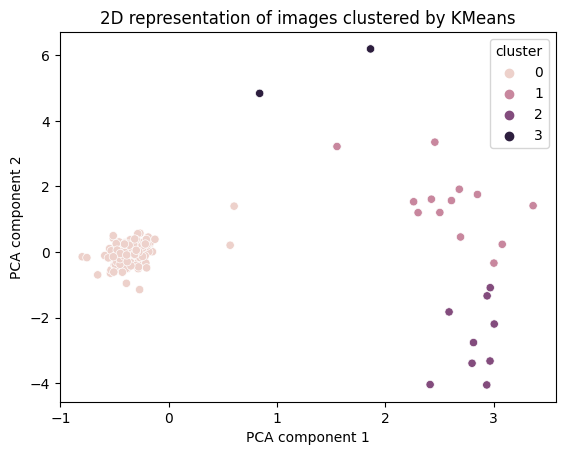

In [18]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

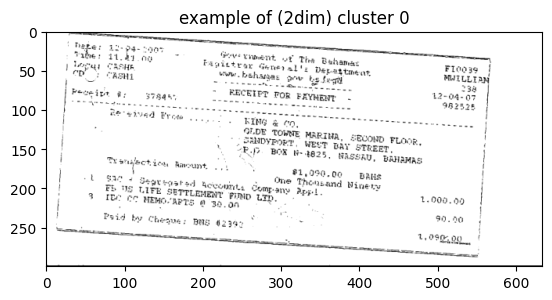

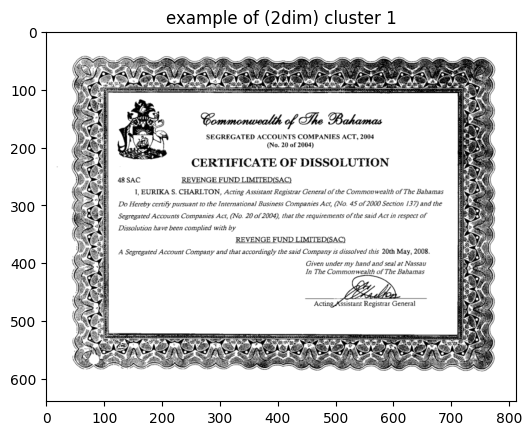

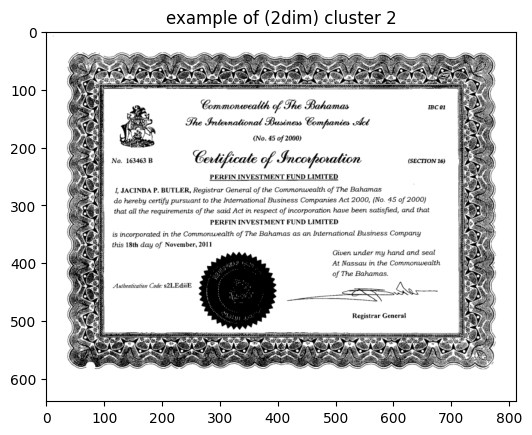

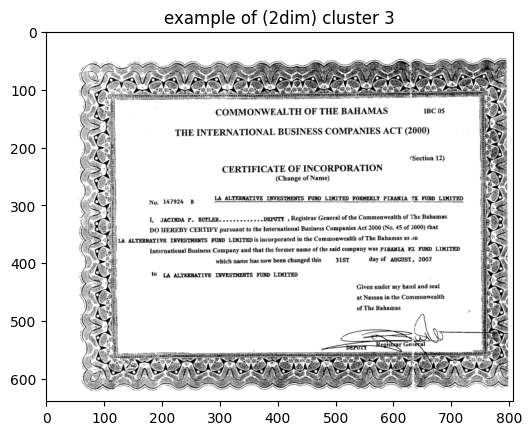

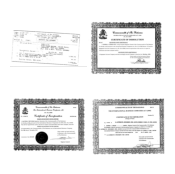

In [19]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_2d_df[pca_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

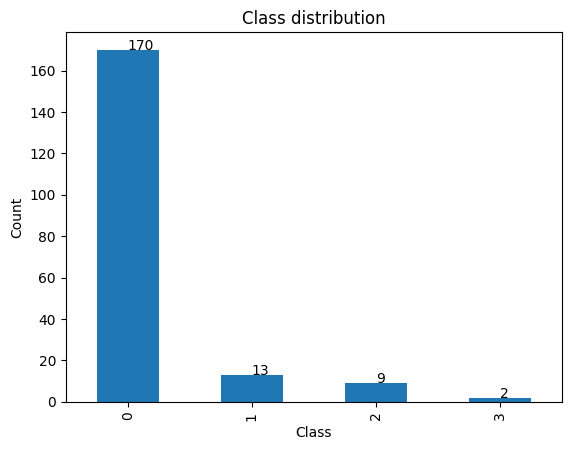

In [20]:
# class/ cluster distribution
pca_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = pca_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])

### Using reconstruction error to find optimal number of components

In [21]:
# https://nannyml.readthedocs.io/en/stable/how_it_works/data_reconstruction.html
from math import dist as eucl_dist
from statistics import mean
reconstruction_err = {}
for num_comp in range(1, max_components + 1, 10):
    pca = decomposition.PCA(n_components=num_comp, svd_solver="randomized", whiten=True)
    pca_img = pca.fit_transform(preprocessed_images_centered)
    reconstruction_err[num_comp] = mean([eucl_dist(x, pca.inverse_transform(y)) for x,y in zip(preprocessed_images_centered, pca_img)])

Text(0.5, 1.0, 'Reconstruction error for different number of principal components')

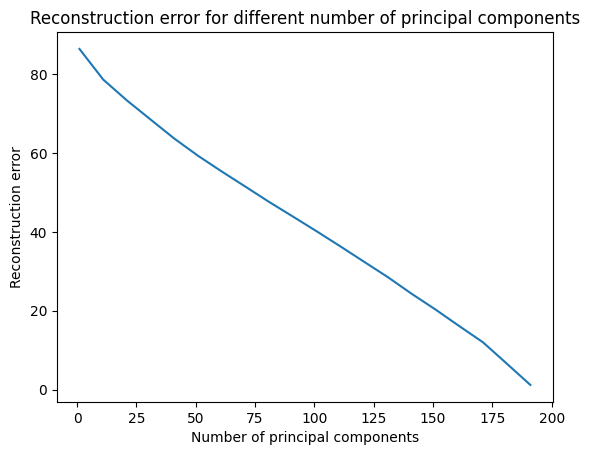

In [22]:
plt.plot(list(reconstruction_err.keys()), list(reconstruction_err.values()))
plt.xlabel('Number of principal components')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error for different number of principal components')

# 13 dim PCA data
best number of components:  13 (cf notebook OPTICS)

In [23]:
d13_pca = decomposition.PCA(n_components=13, svd_solver="randomized", whiten=True)
pca_13d_img = d13_pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', d13_pca.components_.shape, 'Principal axes in feature space = directions of maximum variance')    # (n_new_features/ n_components, n_features)
print('PCA return/ image shape: ', pca_13d_img.shape)  # (n_samples, n_new_features/ n_components)

PCA components:  (13, 360000) Principal axes in feature space = directions of maximum variance
PCA return/ image shape:  (194, 13)


In [24]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_13d_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_13d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_13d_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_13d_img[i]], index=pca_13d_df.index[[i]])

pca_13d_df.to_json('pca_13d_df.json', index=True)
pca_13d_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464032, -0.32715294, 0.23465677, 0.838906..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36624992, 0.29768318, 0.52971834, -0.02535..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669701, 0.20477104, 9.159448, 1.9115276, 5..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884456, 0.30914956, 0.7689858, 0.39089012..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365487, -0.42414385, -0.54463995, -0.178..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549254, -0.070249826, -0.6786364, -0.001..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040616, 0.053367086, 0.16822495, 0.26031..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440584, -0.4825303, -0.046327636, 0.0870..."


# PCA

### PCA components: 
- Principal axes in feature space = directions of maximum variance
- Parallel to eigenvectors

### PCA explained variance:
- Amount of variance explained by each of the selected components
- Ratio: same, but percentage

### PCA n_components:
- Number of components to keep

### PCA return values:
- samples in new (lower dimensional) feature space
